In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
import sys
import torch
from torch_geometric.data import Data
from torch_geometric.data import Dataset, DataLoader
from random import sample 
import os
import networkx as nx
import scipy.io
from scipy.interpolate import griddata


sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk')
print(sys.path)
from pyCaMOtk.create_mesh_hsphere import mesh_hsphere
from pyCaMOtk.create_mesh_hcube import mesh_hcube 
from pyCaMOtk.setup_linelptc_sclr_base_handcode import setup_linelptc_sclr_base_handcode
from pyCaMOtk.create_dbc_strct import create_dbc_strct
from pyCaMOtk.create_femsp_cg import create_femsp_cg
from pyCaMOtk.solve_fem import solve_fem
from pyCaMOtk.visualize_fem import visualize_fem
from pyCaMOtk.lfcnsp import LocalFunctionSpace

sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source')
from FEM_ForwardModel import analyticalHeat3
from GCNNModel import e2vcg2connectivity,PossionNet
from TensorFEMCore_cg import Double,solve_fem_GCNN,create_fem_resjac
import setup_prob_eqn_handcode

torch.manual_seed(0)


c:\Users\puppyCookie\anaconda3\envs\d2l\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\python38.zip', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\DLLs', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l', '', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\Pythonwin']


In [10]:
"""
Hyper prameters
"""
tol=1.0e-16
maxit=2000
# GCNN model
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = PossionNet(nci=3, nco=1, kk=10).to(device)
model=model.double()
#加载模型
#model.load_state_dict(torch.load('C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_heat_6x6.pth'))

cuda


In [11]:
"""
Set up GCNN-FEM Possion problem
"""
# 算Δu
# 
nin=1 # Number of input variable
nvar=1 # Number of primanry variable
etype='hcube' # Mesh type
c=[0,0] # Domain center
r=1 # Radius
porder=1 # Polywwwnomial order for solution and geometry basis
nel=[5,5,10] # Number of element in x and y axis

lims = np.array([[0,1],[0,1],[0,0.5]]) # Domain limits
msh=mesh_hcube(etype,lims,nel,porder).getmsh() # Create mesh object


xcg=msh.xcg # Extract node coordinates
print('xcgshape:',xcg.shape)

#xcg[0]是x坐标，xcg[1]是y坐标
ndof=xcg.shape[1] #总节点数，也就是总自由度数
e2vcg=msh.e2vcg # Extract element connectivity 
connectivity=e2vcg2connectivity(msh.e2vcg,'intra') # Extract element connectivity
#输出一下e2vcg


ndim= 3
[[[ nan   0.   1. ... 246. 247. 248.]
  [ nan   3.   3. ...   3.   3.   3.]]

 [[ nan  nan  nan ... 242. 243. 244.]
  [ nan  nan  nan ...   4.   4.   4.]]

 [[ nan  nan  nan ... 222. 223. 224.]
  [ nan  nan  nan ...   5.   5.   5.]]

 [[  1.   2.   3. ... 248. 249.  nan]
  [  0.   0.   0. ...   0.   0.  nan]]

 [[  5.   6.   7. ...  nan  nan  nan]
  [  1.   1.   1. ...  nan  nan  nan]]

 [[ 25.  26.  27. ...  nan  nan  nan]
  [  2.   2.   2. ...  nan  nan  nan]]]
xcgshape: (3, 396)
NnG: 396
NnE: 250
Nrow: 8


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\GCNNModel.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.from_numpy(np.asarray(connectivity).T).to('cuda'), dtype=torch.long)


In [12]:
bnd2nbc=np.asarray([0]) # Define the boundary tag!
K=lambda x,el: np.asarray([[1],[0],[0],[1]]) #这里肯定要改
Qb=lambda x,n,bnd,el,fc: 0
"""
# The flux constant Flux=[du/dx, du/dy]^T=K dot [dphi/dx,dphi/dy]
where phi is the solution polynomial function
""" 

t0_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[2, i],0)]  
x0_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[0, i],0)] #x=0
x1_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[0, i],1)] #x=1

y0_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[1, i],0)] 
y1_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[1, i],1)]

# 合并所有边界节点索引
dbc_idx = t0_boundary_nodes + x0_boundary_nodes + x1_boundary_nodes + y0_boundary_nodes + y1_boundary_nodes

dbc_idx = np.asarray(dbc_idx)

# 初始化边界值数组
dbc_val = np.zeros_like(dbc_idx, dtype=np.float64)

# 设置边界条件
for idx in range(len(dbc_idx)):
    if dbc_idx[idx] in t0_boundary_nodes:
        #u = sin(pi*x)*sin(pi*y)+x+y
        dbc_val[idx] = np.sin(np.pi * xcg[0, dbc_idx[idx]]) * np.sin(np.pi * xcg[1, dbc_idx[idx]])+xcg[0, dbc_idx[idx]]+xcg[1, dbc_idx[idx]]
    elif dbc_idx[idx] in x0_boundary_nodes:
        #u = y
        dbc_val[idx] = xcg[1, dbc_idx[idx]]
    elif dbc_idx[idx] in x1_boundary_nodes:
        #u = 1+y
        dbc_val[idx] = 1 + xcg[1, dbc_idx[idx]]
    elif dbc_idx[idx] in y0_boundary_nodes:
        #u = x
        dbc_val[idx] = xcg[0, dbc_idx[idx]]
    elif dbc_idx[idx] in y1_boundary_nodes:
        #u = 1+x
        dbc_val[idx] = 1 + xcg[0, dbc_idx[idx]]

print('dbc_val:',dbc_val)
# 创建边界条件结构
dbc = create_dbc_strct(xcg.shape[1] * nvar, dbc_idx, dbc_val)

# 其他参数设置
Src_new = torch.tensor([0.25], dtype=torch.double).to('cuda')
K_new = torch.tensor([[1], [0], [0],[0], [1], [0],[0 ], [0], [0]]).to('cuda').double().reshape((9,))#这里肯定不对
parsfuncI = lambda x: torch.cat((K_new, Src_new), axis=0)

dbc_val: [0.         0.2        0.4        0.6        0.8        1.
 0.2        0.7454915  1.15901699 1.35901699 1.3454915  1.2
 0.4        1.15901699 1.7045085  1.9045085  1.75901699 1.4
 0.6        1.35901699 1.9045085  2.1045085  1.95901699 1.6
 0.8        1.3454915  1.75901699 1.95901699 1.9454915  1.8
 1.         1.2        1.4        1.6        1.8        2.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6        0.8        1.
 0.         0.2        0.4        0.6      

In [5]:
'''
# Define pameterized problem, in this case, the governing equation is changing and the loss
# function is changing
'''
S=[5] # Parametrize the source value in the pde -F_ij,j=S_i
LossF=[]
for i in S: 
	f=lambda x,el: i
	prob=setup_prob_eqn_handcode.setup_linelptc_sclr_base_handcode(2,K,f,Qb,bnd2nbc) # Set up the problem
	femsp=create_femsp_cg(prob,msh,porder,e2vcg,porder,e2vcg,dbc)
	fcn=lambda u_:create_fem_resjac('cg',u_,msh.transfdatacontiguous,
									femsp.elem,femsp.elem_data, 
                   				    femsp.ldof2gdof_eqn.ldof2gdof,
                  			        femsp.ldof2gdof_var.ldof2gdof,
									msh.e2e,femsp.spmat,dbc,[i for i in range(ndof) if i not in dbc_idx],parsfuncI,None)
	LossF.append(fcn)

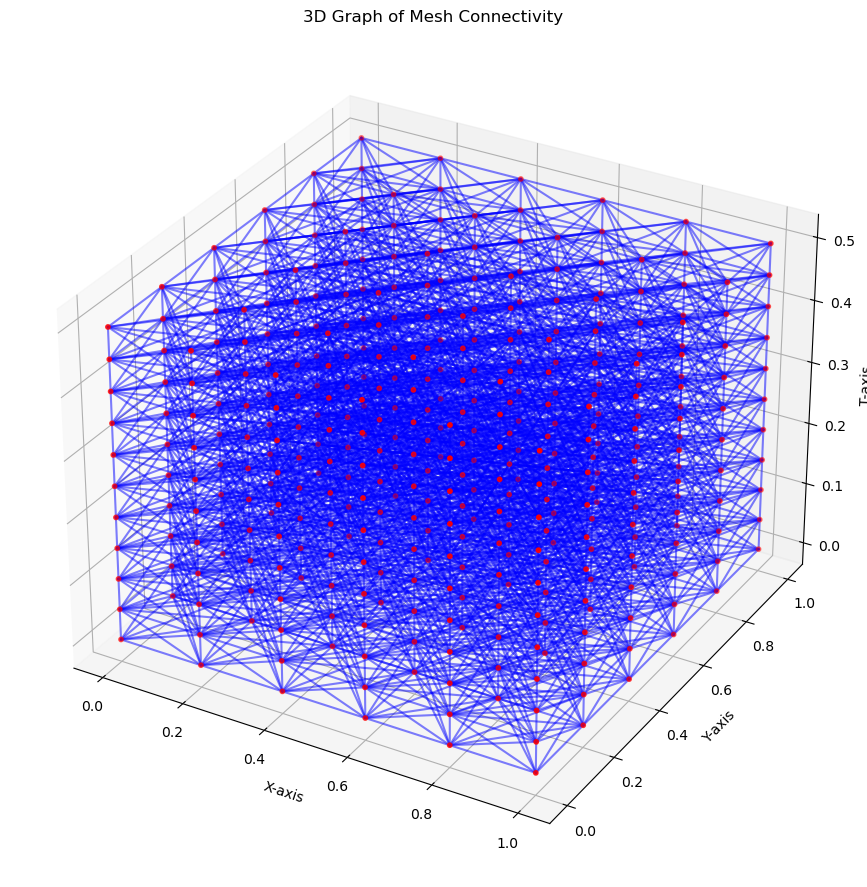

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

edges = connectivity.cpu().numpy().T.tolist()
G = nx.Graph()
G.add_edges_from(edges)
pos = {i: (xcg[0, i], xcg[1, i], xcg[2, i]) for i in range(xcg.shape[1])}

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection='3d')

# 画节点
xs = [pos[i][0] for i in G.nodes()]
ys = [pos[i][1] for i in G.nodes()]
zs = [pos[i][2] for i in G.nodes()]
ax.scatter(xs, ys, zs, c='r', s=10)

# 画边
for edge in G.edges():
    x = [pos[edge[0]][0], pos[edge[1]][0]]
    y = [pos[edge[0]][1], pos[edge[1]][1]]
    z = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x, y, z, c='b', alpha=0.5)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('T-axis')
plt.title('3D Graph of Mesh Connectivity')
plt.show()

In [ ]:
# Define the Training Data
Ufem=analyticalHeat3(xcg)
Graph=[]
ii=0
for i in S:
	Ue=Double(Ufem.reshape(ndof,1))
	fcn_id=Double(np.asarray([ii]))
	Ue_aug=torch.cat((fcn_id,Ue),axis=0)
	Uin=Double(xcg.T)
	graph=Data(x=Uin,y=Ue_aug,edge_index=connectivity)
	Graph.append(graph)
	ii=ii+1
DataList=[[Graph[i]] for i in range(len(S))]
TrainDataloader=DataLoader(DataList,batch_size=1)





# GCNN model
#device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model=PossionNet().to(device)
#model=model.double()
#存储模型
#torch.save(model.state_dict(), 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_heat_6x6.pth')
# Training Data
[model,info]=solve_fem_GCNN(TrainDataloader,LossF,model,tol,maxit)
print('K=',K)
print('Min Error=',info['Er'].min())
print('Mean Error Last 10 iterations=',np.mean(info['Er'][-10:]))
print('Var  Error Last 10 iterations=',np.var(info['Er'][-10:]))

epoch =  0


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\TensorFEMCore.py:324: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  return torch.reshape(input.T,[Shape[len(Shape)-1-i] \
C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\setup_prob_eqn_handcode.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k_ml=torch.tensor(k).double().to('cuda')


Max Rf =============================== tensor(0.1471, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
wallclock time of evl Res=  9.89189076423645
max Res= 0.14706414290574255
wallclock time of this BP=  3.3029682636260986
>>>>>>>max error<<<<<<< ==================================== 0.6179505468682582
>>>>>>>model source<<<<<<< ======================= Parameter containing:
tensor([0.2500], device='cuda:0', dtype=torch.float64, requires_grad=True)
Solution er =  0.6179505468682582
wallclock time of this epoch=  13.440154075622559
The training reaches the expected loss!
epoch =  1
Max Rf =============================== tensor(0.5883, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
wallclock time of evl Res=  9.201067924499512
max Res= 0.5882595850567921
wallclock time of this BP=  3.1065337657928467
>>>>>>>max error<<<<<<< ==================================== 3.2653723043533485
>>>>>>>model source<<<<<<< ======================= Parameter containing:
tensor([0.

KeyboardInterrupt: 

: 

In [ ]:
torch.save(model.state_dict(), 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_heat_55_3d.pth')

In [8]:
# Define the Training Data
Ufem=analyticalHeat3(xcg)
Graph=[]
ii=0
for i in S:
	Ue=Double(Ufem.reshape(ndof,1))
	fcn_id=Double(np.asarray([ii]))
	Ue_aug=torch.cat((fcn_id,Ue),axis=0)
	Uin=Double(xcg.T)
	graph=Data(x=Uin,y=Ue_aug,edge_index=connectivity)
	Graph.append(graph)
	ii=ii+1
DataList=[[Graph[i]] for i in range(len(S))]
TrainDataloader=DataLoader(DataList,batch_size=1)

In [6]:
torch.save(model.state_dict(), 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/2dheat_2000.pth')

torch.Size([396, 1])
solution_values: [[0.        ]
 [0.2       ]
 [0.4       ]
 [0.6       ]
 [0.8       ]
 [1.        ]
 [0.2       ]
 [0.51898592]
 [0.7955944 ]
 [0.99406203]
 [1.1162926 ]
 [1.2       ]
 [0.4       ]
 [0.7954504 ]
 [1.12017313]
 [1.3160923 ]
 [1.38805758]
 [1.4       ]
 [0.6       ]
 [0.99377819]
 [1.31568175]
 [1.51132097]
 [1.58446542]
 [1.6       ]
 [0.8       ]
 [1.11638922]
 [1.38792236]
 [1.5844593 ]
 [1.70521321]
 [1.8       ]
 [1.        ]
 [1.2       ]
 [1.4       ]
 [1.6       ]
 [1.8       ]
 [2.        ]]
ndim= 2
[[[nan  0.  1.  2.  3. nan  5.  6.  7.  8. nan 10. 11. 12. 13. nan 15.
   16. 17. 18. nan 20. 21. 22. 23.]
  [nan  2.  2.  2.  2. nan  2.  2.  2.  2. nan  2.  2.  2.  2. nan  2.
    2.  2.  2. nan  2.  2.  2.  2.]]

 [[nan nan nan nan nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.
   12. 13. 14. 15. 16. 17. 18. 19.]
  [nan nan nan nan nan  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
    3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 1.  2.  3.  4

AttributeError: 'numpy.ndarray' object has no attribute 'tick_params'

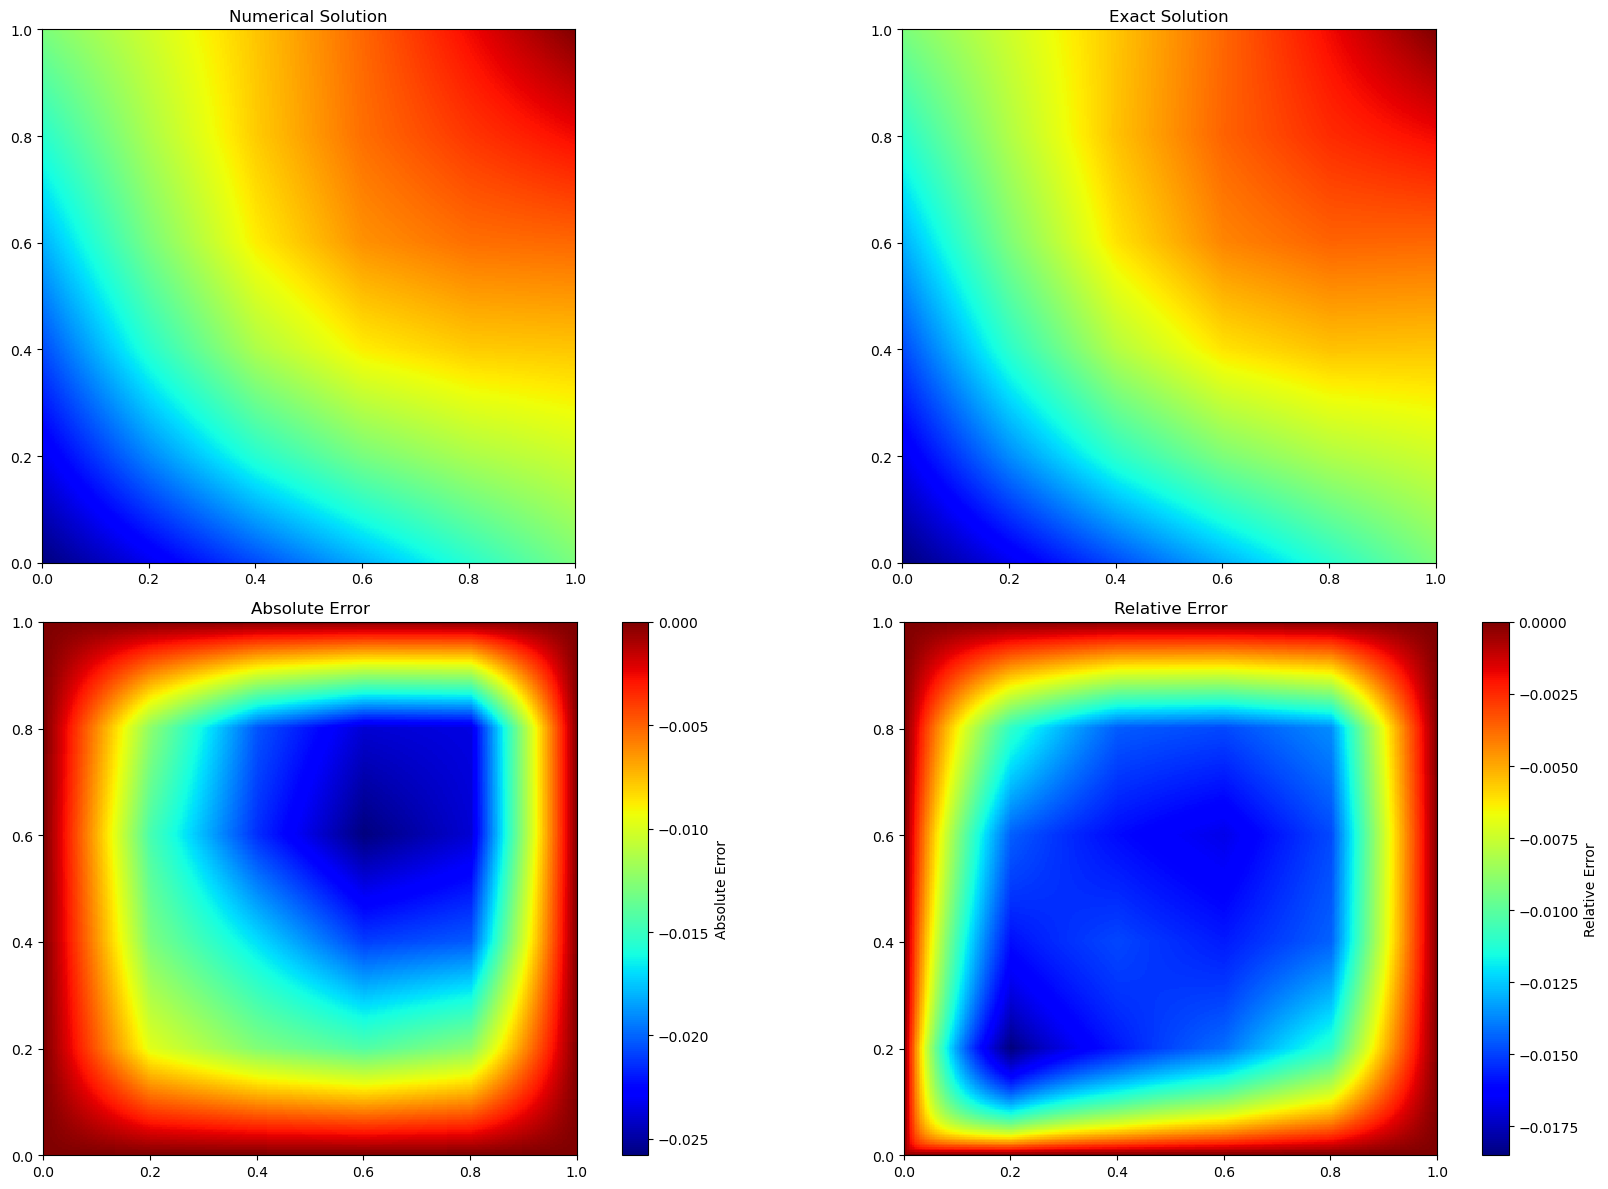

In [17]:
T=0.1
#在xcg[0]中找到T最相近的值的索引
idx = np.where((xcg[2] - T)==0)[0]

Ufem=analyticalHeat3(xcg)

solution=model(Graph[0].to('cuda'))
print(solution.shape)
#solution = Ufem
solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))
solution=solution.detach().cpu().numpy()
solution_values = solution[idx]
print('solution_values:',solution_values)

x_values = xcg[0][idx]
y_values = xcg[1][idx]

Ufem_values = Ufem[idx]
#把Udem_values和solution_values都reshape成和x_values一样的形状
Ufem_values = Ufem_values.reshape(x_values.shape[0],1)
#检查真解和数值解的形状是否一致，如果不一致就统一成solution的形状
porder=1 # Polywwwnomial order for solution and geometry basis
nel=[5,5] # Number of element in x and y axis

lims = np.array([[0,1],[0,1]]) # Domain limits
msh2=mesh_hcube(etype,lims,nel,porder).getmsh() # Create mesh object
ndof=msh2.xcg.shape[1] #总节点数，也就是总自由度数
print('ndof:',ndof)
print(Ufem_values.size)
print(msh2.e2vcg)
#这里要大改！！！👇
if Ufem.shape!=solution.shape:
    Ufem=Ufem.reshape(solution.shape)
fig, axes, cbar = visualize_fem(
    msh2, 
    udg=solution_values, 
    ufem=Ufem_values,        # 传入真解
    opts={"plot_elem": True, "nref": 6}, 
    which_bnd=[]
)

# 分别设置三个子图的标题
titles = ['Numerical Solution', 'Exact Solution', 'Difference']
for ax, title in zip(axes, titles):
    ax.tick_params(axis='both', which='both', 
                   bottom=False, left=False, 
                   top=False, labelbottom=False, labelleft=False)
    ax.set_title(title)
    ax.axis('off')

plt.margins(0,0)
plt.tight_layout()              # 自动调整子图间距
plt.show()

idx: [360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395]
solution_values: [[0.        ]
 [0.2       ]
 [0.4       ]
 [0.6       ]
 [0.8       ]
 [1.        ]
 [0.2       ]
 [0.40186694]
 [0.59812717]
 [0.79753092]
 [0.9937959 ]
 [1.2       ]
 [0.4       ]
 [0.59819057]
 [0.79978887]
 [0.99884508]
 [1.19533796]
 [1.4       ]
 [0.6       ]
 [0.79751649]
 [0.99862945]
 [1.19624776]
 [1.39343478]
 [1.6       ]
 [0.8       ]
 [0.99377936]
 [1.19537714]
 [1.39337351]
 [1.59070513]
 [1.8       ]
 [1.        ]
 [1.2       ]
 [1.4       ]
 [1.6       ]
 [1.8       ]
 [2.        ]]
Ufem_values: [[0.        ]
 [0.2       ]
 [0.4       ]
 [0.6       ]
 [0.8       ]
 [1.        ]
 [0.2       ]
 [0.40248473]
 [0.60402039]
 [0.80402039]
 [1.00248473]
 [1.2       ]
 [0.4       ]
 [0.60402039]
 [0.80650512]
 [1.00650512]
 [1.20402039]
 [1.4       ]
 [0.6       ]
 [0.80402039]
 [1.00650512]
 [1.20650512]
 [1.4

C:\Users\puppyCookie\AppData\Local\Temp\ipykernel_20428\2382995460.py:47: RuntimeWarning: invalid value encountered in divide
  relative_error = np.abs((Ufem_values - solution_values) / Ufem_values)


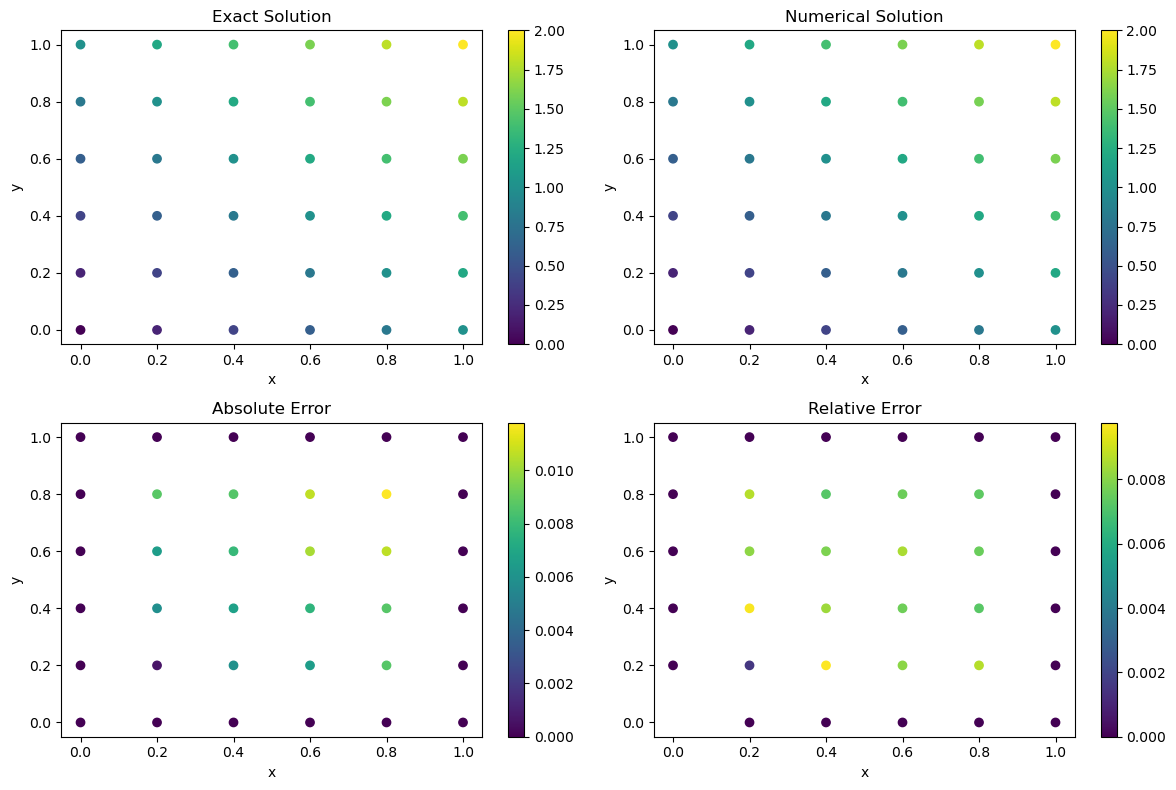

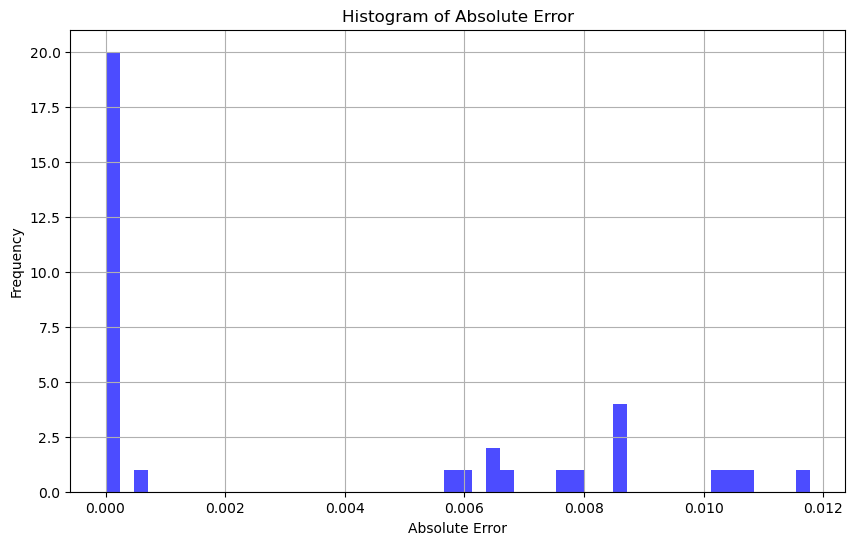

In [15]:
#固定T
Ufem=analyticalHeat3(xcg)
#Ufem.reshape(ndof,1)
solution=model(Graph[0].to('cuda'))
#solution = Ufem
solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))
solution=solution.detach().cpu().numpy()


T=0.5
#在xcg[0]中找到T最相近的值的索引
idx = np.where((xcg[2] - T)==0)[0]
print('idx:',idx)
#提取对应的x坐标和解值
x_values = xcg[0][idx]
y_values = xcg[1][idx]
solution_values = solution[idx]
Ufem_values = Ufem[idx]
#把Udem_values和solution_values都reshape成和x_values一样的形状
Ufem_values = Ufem_values.reshape(x_values.shape[0],1)
#reshape一下

print('solution_values:',solution_values)
print('Ufem_values:',Ufem_values)
#画四张热力图 ，真值、数值解和绝对误差、相对误差
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# 画出真值
sc = axes[0, 0].scatter(x_values, y_values, c=Ufem_values, cmap='viridis')
axes[0, 0].set_title('Exact Solution')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(sc, ax=axes[0, 0])
# 画出数值解
sc = axes[0, 1].scatter(x_values, y_values, c=solution_values, cmap='viridis')
axes[0, 1].set_title('Numerical Solution')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(sc, ax=axes[0, 1])
# 画出绝对误差
absolute_error = np.abs(Ufem_values - solution_values)
sc = axes[1, 0].scatter(x_values, y_values, c=absolute_error, cmap='viridis')
axes[1, 0].set_title('Absolute Error')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(sc, ax=axes[1, 0])
# 画出相对误差
relative_error = np.abs((Ufem_values - solution_values) / Ufem_values)
sc = axes[1, 1].scatter(x_values, y_values, c=relative_error, cmap='viridis')
axes[1, 1].set_title('Relative Error')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(sc, ax=axes[1, 1])
plt.tight_layout()
plt.show()
# 画出误差的直方图
plt.figure(figsize=(10, 6))
plt.hist(absolute_error, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Absolute Error')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

